<a href="https://colab.research.google.com/github/Anastasiya9323/machineLearning/blob/main/task1112point5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [36]:
import torchvision.datasets
from torchvision.models import resnet18

In [37]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [39]:
len(y_train), len(y_test)

(50000, 10000)

In [40]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [41]:
X_train /= 255.
X_test /= 255.

In [42]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

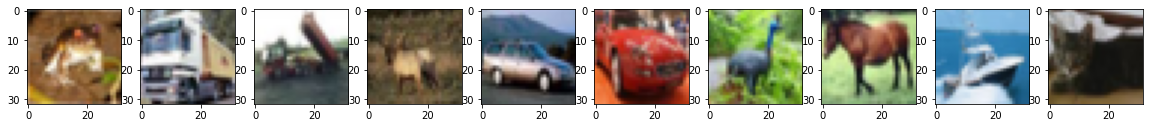

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [44]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [45]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [46]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [47]:
def train(net, X_train, y_train, X_test, y_test, weight_decay=0):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=weight_decay)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()
        with torch.no_grad():
          test_preds = net.forward(X_test)
          loss_value = loss(test_preds, y_test).item()
          test_loss_history.append(loss_value)

          accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
          test_accuracy_history.append(accuracy)

        print(accuracy)
    print('---------------')
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

In [48]:
class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A', 
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(BasicBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.act  = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.d_out2 = torch.nn.Dropout2d(d_out_p)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """https://www.kaggle.com/mrtahion/kernel63a29c282a?scriptVersionId=17181076
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x: torch.nn.functional.pad(x[:, :, ::2, ::2], \
                                            (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = torch.nn.Sequential(
                     torch.nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     torch.nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
          out = self.bn1(out)
        if self.use_drop_out:
          out = self.d_out1(out) 
        out = self.act(out)
        out = self.conv2(out)
        
        if self.use_batch_norm:
          out = self.bn2(out)
        if self.use_drop_out:
          out = self.d_out2(out)
          
        out += self.shortcut(x)
        out = self.act(out)
        return out


class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(ResNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.in_planes = 16
        self.act  = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,
                                use_batch_norm=self.use_batch_norm,
                               use_drop_out=self.use_drop_out, 
                               d_out_p=self.d_out_p))
            self.in_planes = planes * block.expansion

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
          out = self.bn1(out)
        if self.use_drop_out:
          out = self.d_out1(out)
          
        out = self.act(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



In [49]:
def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

In [50]:
accuracies['resnet20'], losses['resnet20'] = \
    train(resnet20(), X_train, y_train, X_test, y_test)

accuracies['resnet20 weight_decay=1e-2'], losses['resnet20 weight_decay=1e-2'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-2)

accuracies['resnet20 weight_decay=1e-3'], losses['resnet20 weight_decay=1e-3'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-3)

accuracies['resnet20 weight_decay=1e-4'], losses['resnet20 weight_decay=1e-4'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-4)

accuracies['resnet20 weight_decay=1e-5'], losses['resnet20 weight_decay=1e-5'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-5)

accuracies['resnet20 weight_decay=1e-6'], losses['resnet20 weight_decay=1e-6'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-6)

0.541700005531311
0.6796000003814697
0.7014999985694885
0.6897000074386597
0.7382999658584595
0.7462999820709229
0.7942000031471252
0.7813999652862549
0.7980999946594238
0.7627999782562256
0.8093999624252319
0.7996999621391296
0.795199990272522
0.7639999985694885
0.7997999787330627
0.7820999622344971
0.7839999794960022
0.8007000088691711
0.7683999538421631
0.7789999842643738
0.7962999939918518
0.7982999682426453
0.7996999621391296
0.7996000051498413
0.7757999897003174
0.807699978351593
0.811199963092804
0.7908999919891357
0.8000999689102173
0.8004999756813049
---------------
0.520799994468689
0.6158999800682068
0.592799961566925
0.5697999596595764
0.6017999649047852
0.6527999639511108
0.7053999900817871
0.6688999533653259
0.7224999666213989
0.7109999656677246
0.618399977684021
0.7583999633789062
0.7132999897003174
0.7202000021934509
0.7215999960899353
0.6387999653816223
0.7525999546051025
0.7642999887466431
0.7231999635696411
0.6916999816894531
0.7676999568939209
0.7116999626159668
0.6

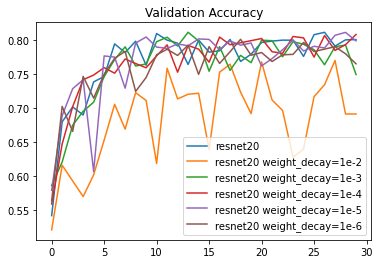

In [51]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

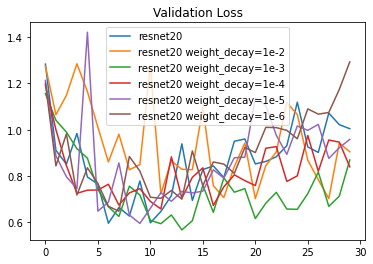

In [52]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');